In [194]:
# !pip install pandas --upgrade  --quiet
# !pip install numpy --upgrade  --quiet
# !pip install scipy --upgrade  --quiet
# !pip install statsmodels --upgrade  --quiet
# !pip install scikit-learn --upgrade  --quiet
# !pip install missingno --upgrade  --quiet
!pip install apafib --upgrade --quiet

Objetivos de aprendizaje:
1. Hacer un mínimo análisis exploratorio de un conjunto de datos
2. Hacer el preproceso de un conjunto de datos para usar regresión
3. Saber plantear problemas de regresión sencillos y resolverlos usando diferentes
métodos
4. Interpretar los resultados de un problema de regresión

# Problema 1
El coste de los seguros médicos varía bastante según las circunstancias de cada persona, pero a veces averiguar como se calcula realmente no es tan sencillo. El conjunto de datos Medical Cost Personal Dataset tiene la descripción de las características de un grupo de personas y los cargos de su seguro médico. Nos interesa predecir esta última variable ($charges$).
Trabajaremos con una versión de este conjunto que podéis obtener mediante la función `load_medical_costs` de la librería `apafib`.

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

from apafib import load_medical_costs

medical = load_medical_costs()
medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Apartat a)
 - Dividir el conjunt en (70%/30%) i fer una exploració mínima del conjunt de dades.
 - Aplicar PCA a les dades i representar la variable resposta en els dos primers components.
 - Transformar les variables per poder ajustar un model de regressió.

 ---

### Dividir el conjunt i exploració inicial


In [196]:
medical_train, medical_test = train_test_split(medical, test_size=0.3, random_state=92)

print("Diviri el conjunt de dades en entrenament i test en una proporció 70/30:")
print("-"*70)
print(f"Mida conjunt entrenament: {medical_train.shape}")
print(f"Mida conjunt test: {medical_test.shape}")
print()

Diviri el conjunt de dades en entrenament i test en una proporció 70/30:
----------------------------------------------------------------------
Mida conjunt entrenament: (936, 7)
Mida conjunt test: (402, 7)



### Comprovar valors perduts
Per poder decidir que fer amb el processament de dades, hem de mirar si existeix algun valor perdut, ja que en el cas que hi hagin hauriem de decidir com tractasr-los, si eliminar-los o substituir el seu valor. També haurem de mirar el tipus de dades, si són numeriques o bé categòriques.

In [197]:
print("\nClases i tipus de dades:")
medical.info()
print('-' * 90)
print("\nValors nuls:")
print(medical_train.isna().sum())


Clases i tipus de dades:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
------------------------------------------------------------------------------------------

Valors nuls:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Veiem que no existeix cap valor perdut, així que no ens hem de preocupar per tractar-los.
Examinem les característiques del dataset, i podem veure que existeixen 3 variables categoriques i 4 de numériques.

Les variables categòriques son : {$sex$, $smoker$, $region$}.

I per tant les númeriques les restants : {$age$, $bmi$, $children$} i evidentment la nostre variable objectiu $charges$.

In [198]:
print('\n Descripció estadística de les variables numèriques:')
medical_train.describe()


 Descripció estadística de les variables numèriques:


,age,bmi,children,charges
count,936.000000,936.000000,936.000000,936.000000
mean,39.349359,30.555134,1.105769,13058.820196
std,13.879418,6.071248,1.198274,11821.608605
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.111250,0.000000,4710.601913
50%,40.000000,30.275000,1.000000,9289.083100
75%,51.000000,34.430000,2.000000,16328.508137
max,64.000000,52.580000,5.000000,62592.873090


In [199]:
print("\nDistribució de les variables categòriques:")
print(medical_train['sex'].value_counts())
print('-' * 90)
print(medical_train['smoker'].value_counts())
print('-' * 90)
print(medical_train['region'].value_counts())


Distribució de les variables categòriques:
sex
male      477
female    459
Name: count, dtype: int64
------------------------------------------------------------------------------------------
smoker
no     747
yes    189
Name: count, dtype: int64
------------------------------------------------------------------------------------------
region
southeast    252
northwest    239
northeast    223
southwest    222
Name: count, dtype: int64


Respecte les variables categòriques:

Podem veure que el dataset d'entrenament, tant les variables $sex$ i $region$ estan bastant balancejats, però el problema està amb $smoker$ que tenen una distribució de 80%/20%, però tot i que sigui de les variables més desbalancejades, segurament és una de les que més predictives.

Què més és pot observar? 
De les variables numériques, $charges$ podem veure que esta bastant desbalancejada, ja que la mediana (9289.083100) està bastant per sota de la mitjana (13058.820196), l'alta desviació estàndar i el máxim (62592.873090) ens indica que hi haurà outliers.

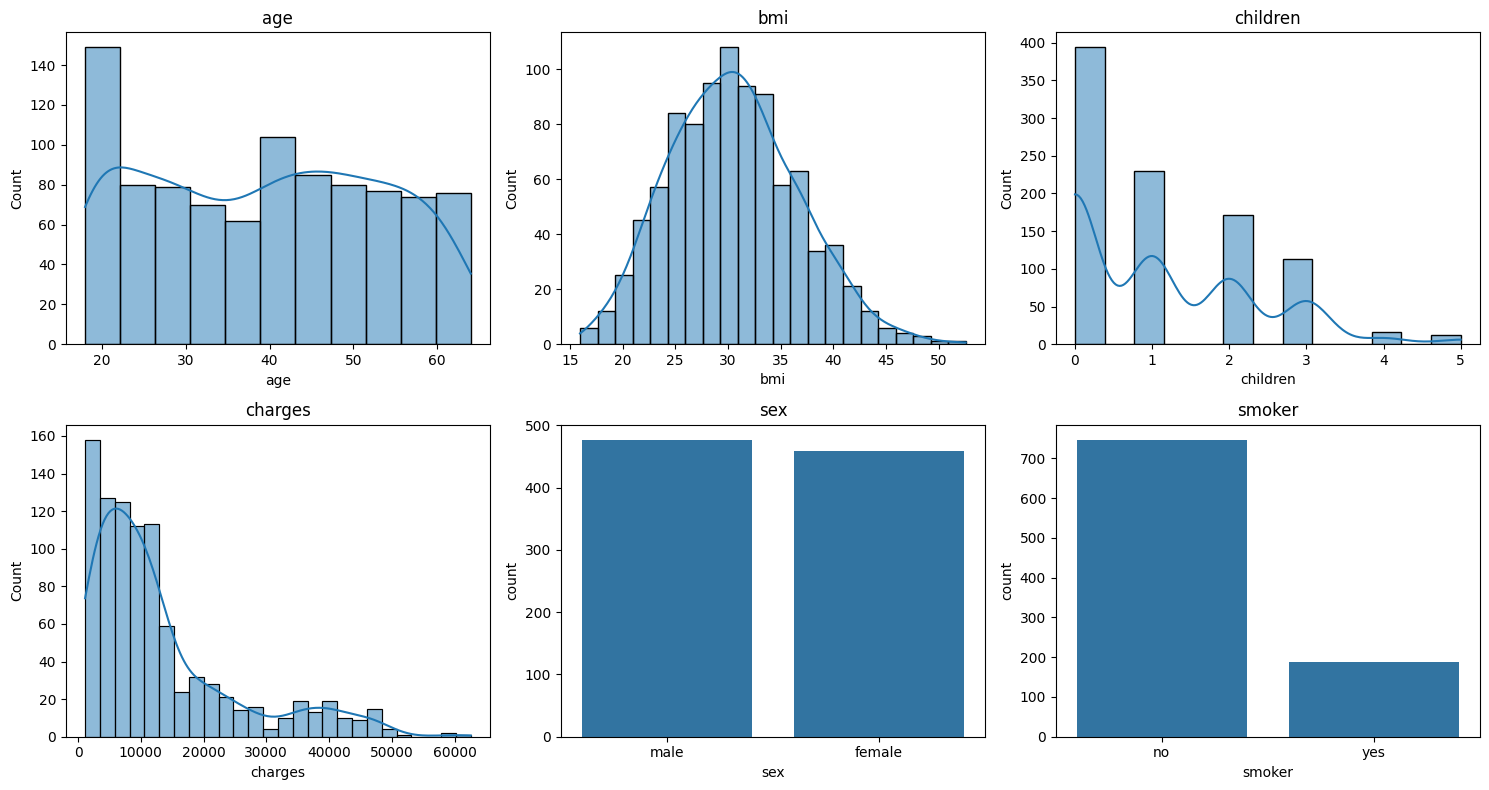

In [200]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, col in enumerate(['age','bmi','children','charges']):
    ax = axes[i]
    sns.histplot(medical_train[col], kde=True, ax=ax)
    ax.set_title(col)

sns.countplot(x='sex', data=medical_train, ax=axes[4])
axes[4].set_title('sex')
sns.countplot(x='smoker', data=medical_train, ax=axes[5])
axes[5].set_title('smoker')
plt.tight_layout()
plt.show()


Amb aquests boxplots podem veure la distribució de les variables. 
Primer farem un estudi de les variables númeriques i després ja ens posarem amb les categòriques. El que veurem ara será:
- Les relacions en cada variable amb l'objectiu $charges$.
- La matriu de correlacions


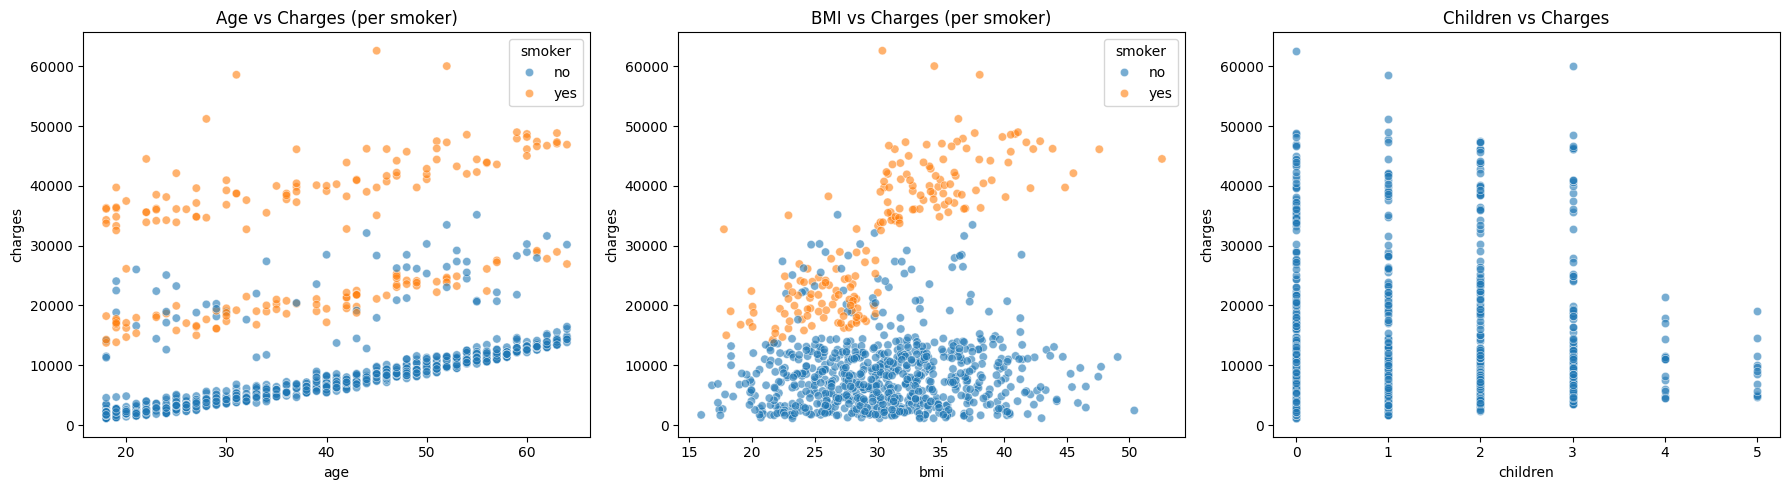

In [201]:
fig, axes = plt.subplots(1,3, figsize=(18,5))
sns.scatterplot(x='age', y='charges', hue='smoker', data=medical_train, ax=axes[0], alpha=0.6)
axes[0].set_title('Age vs Charges (per smoker)')

sns.scatterplot(x='bmi', y='charges', hue='smoker', data=medical_train, ax=axes[1], alpha=0.6)
axes[1].set_title('BMI vs Charges (per smoker)')

sns.scatterplot(x='children', y='charges', data=medical_train, ax=axes[2], alpha=0.6)
axes[2].set_title('Children vs Charges')

plt.tight_layout()
plt.show()



Veurem les correlacions de les variables numériques i com afecten a la variable objectiu $charges$, així podrem decidir quines son més predictives i quines ho son menys.

,age,bmi,children,charges
age,1.000000,0.093717,0.003371,0.298043
bmi,0.093717,1.000000,-0.021719,0.173085
children,0.003371,-0.021719,1.000000,0.068983
charges,0.298043,0.173085,0.068983,1.000000


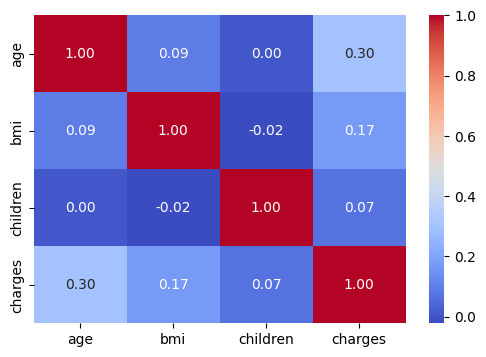

In [202]:
num_cols = ['age','bmi','children','charges']
corr = medical_train[num_cols].corr()
display(corr)
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Que podem observar segons les variables amb la objetiu?
- $age$: sembla ser la variable amb la correlació més alta amb $charges$. Això indica que, en general, els costos augmenten amb l'edat.
- $bmi$: mostra correlació positiva amb $charges$. A més, pels gràfics es veu una interacció important amb $smoker$: els individus amb BMI elevat que també són fumadors tendeixen a tenir càrrecs signficatviament més elevats.
- $children$: és la variable amb menys correlació amb $charges$ i aporta poca variabilitat, és a dir, probablement aporta poca predectivitat.

Ara analitzem una mica per sobre les variables categòriques:

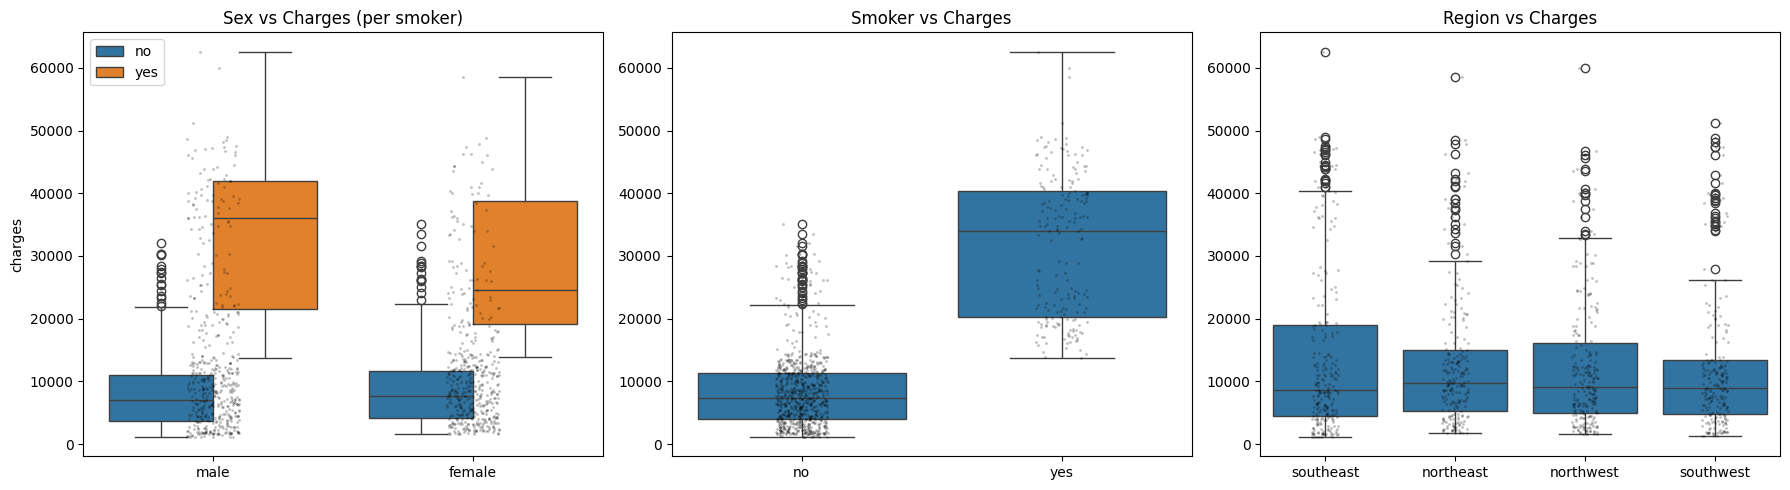

In [203]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sex vs charges per smoker (box + points)
sns.boxplot(x='sex', y='charges', hue='smoker', data=medical_train, ax=axes[0])
sns.stripplot(x='sex', y='charges', data=medical_train, ax=axes[0], color='k', size=2, jitter=True, alpha=0.25)
axes[0].set_title('Sex vs Charges (per smoker)')
axes[0].set_xlabel('')
axes[0].set_ylabel('charges')

# Smoker vs charges (box + points)
sns.boxplot(x='smoker', y='charges', data=medical_train, ax=axes[1])
sns.stripplot(x='smoker', y='charges', data=medical_train, ax=axes[1], color='k', size=2, jitter=True, alpha=0.25)
axes[1].set_title('Smoker vs Charges')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Region vs charges (box + points) — rotar etiquetes
sns.boxplot(x='region', y='charges', data=medical_train, ax=axes[2])
sns.stripplot(x='region', y='charges', data=medical_train, ax=axes[2], color='k', size=2, jitter=True, alpha=0.25)
axes[2].set_title('Region vs Charges')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

Sobre les variables categòriques:
- $smoker$: La variable $smoker$ mostra una associació molt clara amb $charges$, veiem que les perdones que fumen, tenen càrrec molt més alts en comparació amb els no fumadors. És una relació que ja havíem vist abans comparant les variables numériques amb $charges$ separant per fumadors i no.
- $sex$ i $region$: No es nota gaire diferència amb $charges$, és a dir, a simple vista no es nota un gran variabilitat pertanyer a un grup o bé en un altre.

---

Després d'aquest analisis bàsic, hem vist que les variables més signficatives per prediure $charges$, són $bmi$, $smoker$ i $age$.

---

### Transformar les dades i aplicar PCA

Després d'aquest estudi, ja es un bon moment per aplciar PCA, però primer hem de preparar les variables.
Començarem separant les variables de la variable objectiu, després passant-les totes a numériques i finalment estandaralitzant-les.

X_train: (936, 6), y_train: (936,)
X_test: (402, 6), y_test: (402,)
------------------------------------------------------------------------------------------
Desviació estandard (hauria de ser 1): [1. 1. 1. 1. 1. 1.]
Mitjana (hauria de ser molt propera a 0): [ 2.20146788e-16  2.94161656e-17  3.63431982e-16 -4.22264313e-17
 -7.97083197e-17 -7.59126854e-18]
------------------------------------------------------------------------------------------

 variància per component:
  PC1: 0.1979 (19.79%)
  PC2: 0.1833 (18.33%)
  PC3: 0.1681 (16.81%)
  PC4: 0.1651 (16.51%)
  PC5: 0.1535 (15.35%)
  PC6: 0.1322 (13.22%)

 variància acumulada:
  Primeros 1 componentes: 0.1979 (19.79%)
  Primeros 2 componentes: 0.3811 (38.11%)
  Primeros 3 componentes: 0.5492 (54.92%)
  Primeros 4 componentes: 0.7143 (71.43%)
  Primeros 5 componentes: 0.8678 (86.78%)
  Primeros 6 componentes: 1.0000 (100.00%)
------------------------------------------------------------------------------------------


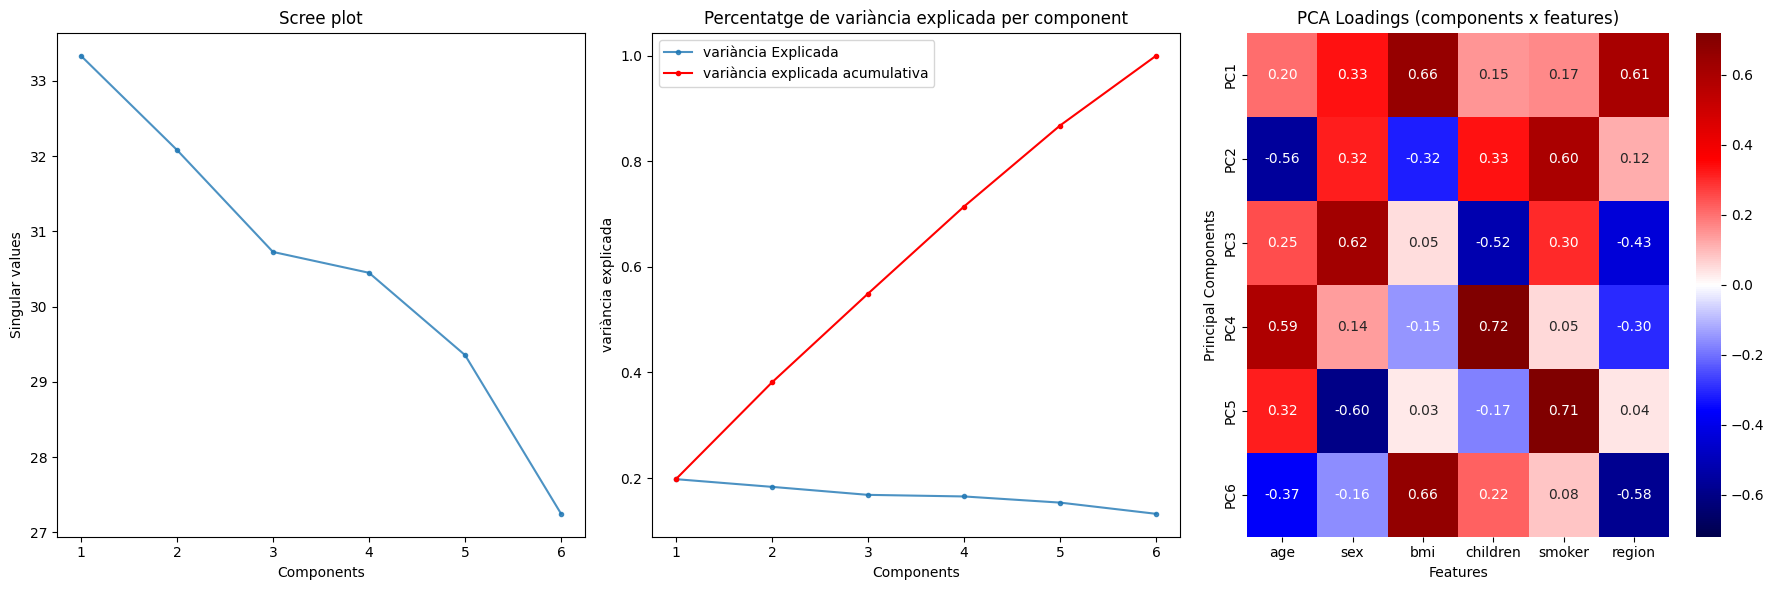

In [204]:
X_train = medical_train.drop('charges', axis=1)
y_train = medical_train['charges']
X_test = medical_test.drop('charges', axis=1)
y_test = medical_test['charges']
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

var_categoriques = ['sex', 'smoker', 'region']
var_numeriques = ['age', 'bmi', 'children']

#Per poder aplicar PCA, totes les variables han de ser numeriques
X_train_num = X_train.copy()
X_test_num = X_test.copy()

label_encoders = {}
for col in var_categoriques:
    le = LabelEncoder()
    X_train_num[col] = le.fit_transform(X_train[col])
    X_test_num[col] = le.transform(X_test[col])
    label_encoders[col] = le


scaler = StandardScaler()
X_train_standarized = scaler.fit_transform(X_train_num)   
X_test_standarized = scaler.transform(X_test_num)

print('-' * 90)
print(f"Desviació estandard (hauria de ser 1): {X_train_standarized.std(axis=0)}")
print(f"Mitjana (hauria de ser molt propera a 0): {X_train_standarized.mean(axis=0)}")
print('-' * 90)

myPCA = PCA().fit(X_train_standarized)
myPCA_test = PCA().fit(X_test_standarized)

print("\n variància per component:")
for i, var in enumerate(myPCA.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

print(f"\n variància acumulada:")
cumsum_var = np.cumsum(myPCA.explained_variance_ratio_)
for i, var in enumerate(cumsum_var):
    print(f"  Primeros {i+1} componentes: {var:.4f} ({var*100:.2f}%)")

print('-' * 90)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes[0].plot(range(1,len(myPCA.singular_values_ )+1),myPCA.singular_values_ ,alpha=0.8,marker='.')
y_label = axes[0].set_ylabel('Singular values')
x_label = axes[0].set_xlabel('Components')
axes[0].set_title('Scree plot')
axes[1].plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="variància Explicada")
y_label = axes[1].set_ylabel('variància explicada')
x_label = axes[1].set_xlabel('Components')
axes[1].plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="variància explicada acumulativa")
axes[1].legend()
axes[1].set_title('Percentatge de variància explicada per component')

sns.heatmap(
    myPCA.components_,
    ax=axes[2],
    cmap='seismic',
    xticklabels=list(X_train_num.columns),
    yticklabels=[f'PC{i+1}' for i in range(myPCA.components_.shape[0])],
    vmin=-np.max(np.abs(myPCA.components_)),
    vmax=np.max(np.abs(myPCA.components_)),
    annot=True,
    fmt='.2f'
)
axes[2].set_title('PCA Loadings (components x features)')
axes[2].set_xlabel('Features')
axes[2].set_ylabel('Principal Components')

plt.tight_layout(h_pad=3.0)
plt.show()


Podem observar que tant l'estandardització com les mitjanes són correctes: la desviació estàndard és 1 i les mitjanes estan molt properes a 0, per la qual cosa podem aplicar PCA sense problemes.

Observem també que la variància està força distribuïda entre tots els components, cap destaca respecte la resta. Per arribar al 50% de variància, hauriem de tenir en conta PC1, PC2 i PC3.

---

Ara mirarem el PCA en els dos primers components, però hem de tenir en conta que només abarca el 38% de la variància total.


Variància explicada per PC1: 19.79%
Variància explicada per PC2: 18.33%
Variancia total (PC1+PC2): 38.11%

Loadings (PC1 i PC2):
               PC1       PC2
age       0.203990 -0.558114
sex       0.332103  0.316620
bmi       0.657527 -0.319983
children  0.148473  0.333944
smoker    0.165873  0.600858
region    0.605141  0.115426
------------------------------------------------------------------------------------------


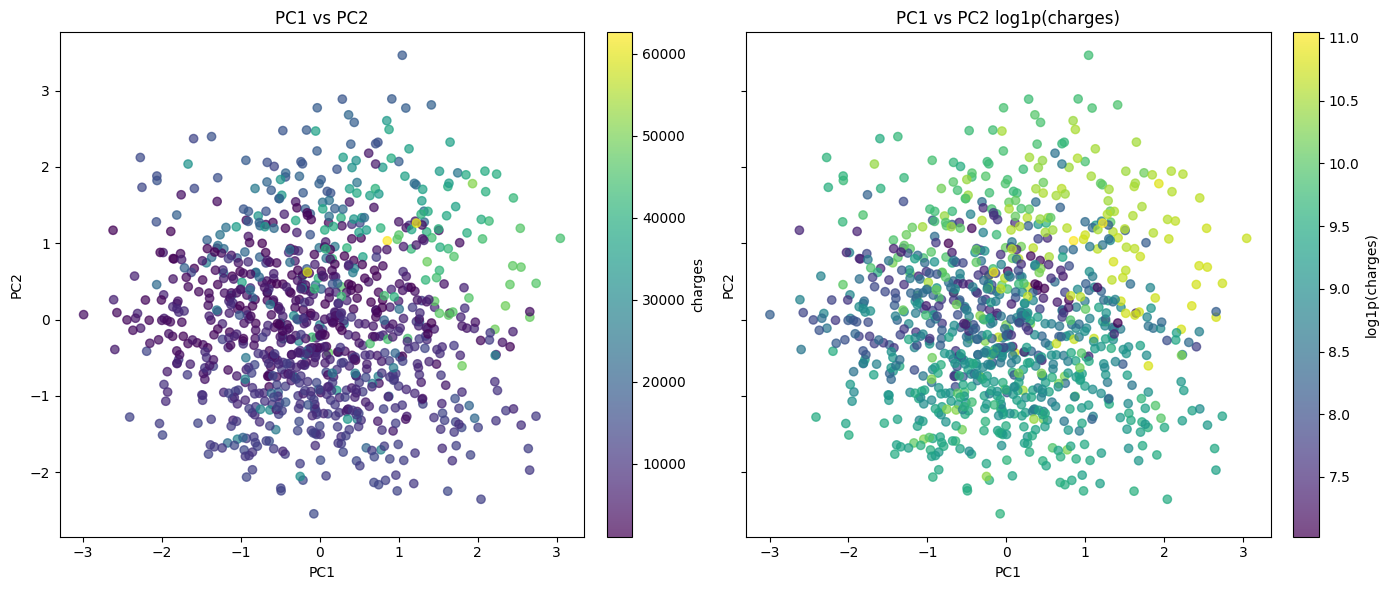

,age,sex,bmi,children,smoker,region
976,48,1,40.150,0,0,2
46,18,0,38.665,2,0,0
896,43,0,20.045,2,1,0
199,64,0,39.330,0,0,0
190,61,1,31.570,0,0,2


In [205]:
myPCA2 = myPCA.transform(X_train_standarized)

print(f"\nVariància explicada per PC1: {myPCA.explained_variance_ratio_[0]*100:.2f}%")
print(f'Variància explicada per PC2: {myPCA.explained_variance_ratio_[1]*100:.2f}%')
print(f"Variancia total (PC1+PC2): {myPCA.explained_variance_ratio_[:2].sum()*100:.2f}%")

print("\nLoadings (PC1 i PC2):")
loadings = pd.DataFrame(
    myPCA.components_.T[:, :2],
    columns=['PC1', 'PC2'],
    index=X_train_num.columns
)
print(loadings)
print('-'*90)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

sc1 = axes[0].scatter(
    myPCA2[:, 0], myPCA2[:, 1],
    c=y_train.values, cmap='viridis', alpha=0.7
)
axes[0].set_title('PC1 vs PC2')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

cbar1 = fig.colorbar(sc1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('charges')

sc2 = axes[1].scatter(
    myPCA2[:, 0], myPCA2[:, 1],
    c=np.log1p(y_train.values), cmap='viridis', alpha=0.7
)
axes[1].set_title('PC1 vs PC2 log1p(charges)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
cbar2 = fig.colorbar(sc2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('log1p(charges)')

plt.tight_layout()
plt.show()

X_train_num.head()


Bé, com ja hem explicat abans, si agafem només les dues primeres components, només representem un 38.1% de la variància total.
Respecte PC1, veiem que les variables $bmi$ i $region$ son les que tenen major influència de 0.657527 i 0.605141 respectivament. I també veiem que la que té menys importància es $children$. Xoca que $smokers$ tingui un pes tan baix en PC1 (0.165873). És a dir, PC1 sembla més que relacioni el $bmi$ depenent de la $regio$.
Respecte PC2, les carregues més importants canvien comparant amb PC1, aquí veiem que les que més criden l'atenció son $smoker$ amb 0.600858 i $age$ amb un pes negatiu de -0.558114, amb aquestes dades podem intuir que PC2 separa la gent fumadora i no fumadora i l'edat.

En el primer gràfic, els punts es coloregen segons el valor original de $charges$, on s'observa una clara separació en quatre grups de color que corresponen a les quatre regions geogràfiques. Això confirma que PC1, dominada pel $bmi$ (0.657527) i la $region$ (0.600858), reflecteix diferències geogràfiques en el pes corporal, suggerint que certes regions tenen poblacions amb $bmi$ més alt.

En canvi, el segon gràfic $log1p(charges)$, que utilitza la transformació logarítmica dels costos, ens permet veure millor els patrons. Aquí s'aprecia clarament $smoker$, $age$ i el $bmi$ influeixen conjuntament en el valor dels costos mèdics. 
La transformació logarítmica permet visualitzar millor com aquestes variables depene per determinar el cost médic, especialment destacant l'impacte de ser fumador.

*Com que al llarg del procediment per aplicar el PCA ja hem transformat els dades del test, no ho farem al final.

---

## Apartat b)
 - Ajustar un model de regresió lineal per prediure la variable objectiu y estimar la qualitat de regressió.
 - Representar els residus de la regressió i les prediccions amb els valors reals.
 - Ajustar la regressió amb _statsmodels_

---

### Regressió lineal i estimació de la qualitat


In [206]:
lr = LinearRegression()
lr.fit(X_train_standarized, y_train)

y_pred_train = lr.predict(X_train_standarized)
y_pred_test = lr.predict(X_test_standarized)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)



print(f"R2 entrenament: {r2_train:.4f}, MSE entrenament: {mse_train:.2f}, RMSE entrenament: {rmse_train:.4f} MAE entrenament: {mae_train:.4f}")
print(f"R2 test: {r2_test:.4f}, MSE test: {mse_test:.2f}, RMSE test: {rmse_test:.4f} MAE test: {mae_test:.4f}")



R2 entrenament: 0.7469, MSE entrenament: 35332412.63, RMSE entrenament: 5944.1074 MAE entrenament: 4052.3770
R2 test: 0.7557, MSE test: 39665637.77, RMSE test: 6298.0662 MAE test: 4318.4807


Veiem que:
- R² té un valor significativament alt de 74.69%, és a dir, explica una gran part de la variància de $charges$; és un ajustament força bo per un model lineal senzill.
- MSE ens indica la mitja dels errors al quadrat, aquest valor depèn de l'escala de la variable $charges$ i per si sol no és fàcil d'interpretar (per això després apliquem RMSE i MAE).
- RMSE: 5944.11 significa que la desviació típica dels errors és d'aproximadament 5.944 unitats (en la escala que $charges$).
- MAE: 4052.38 L'error absolut mitjà és d'uns $4,052, és a dir, en mitjana les prediccions s'equivoquen en aproximadament $4,000 respecte al valor real.

Interpretació ràpida:
- Un R² ~0.75 és força raonable i indica que el model lineal captura bona part de la variabilitat, però si fem una mica més de zoom, veiem que RMSE/MAE ens diuen que encara hi ha errors absoults importants.

### És suficientment bo?

En termes generals, sí, el model és bo.
- L' R² del 75% indica que el model explica tres quart de la variabilitat de $charges$.
- Tant les dades de train com les de test, son molt similars, el que ens indica que el model es generalitza bé.
- Tot i que es bo, es millorable, el RMSE és molt alt, i la diferència entre RMSE i MAE ens fa pensa que hi ha outliers.
- ja que l'R² es indica que representa més del 70%, també podem dir que es bo ja que tan train com test tenen dades bastants similars, és a dir, s'ajusta igual de bé en les dues. Però cal destacar que tot i així, el RMSE es bastant alt. En general, el model és prou bo, però millorable.

---

### Representació dels residus i prediccions amb valors reals

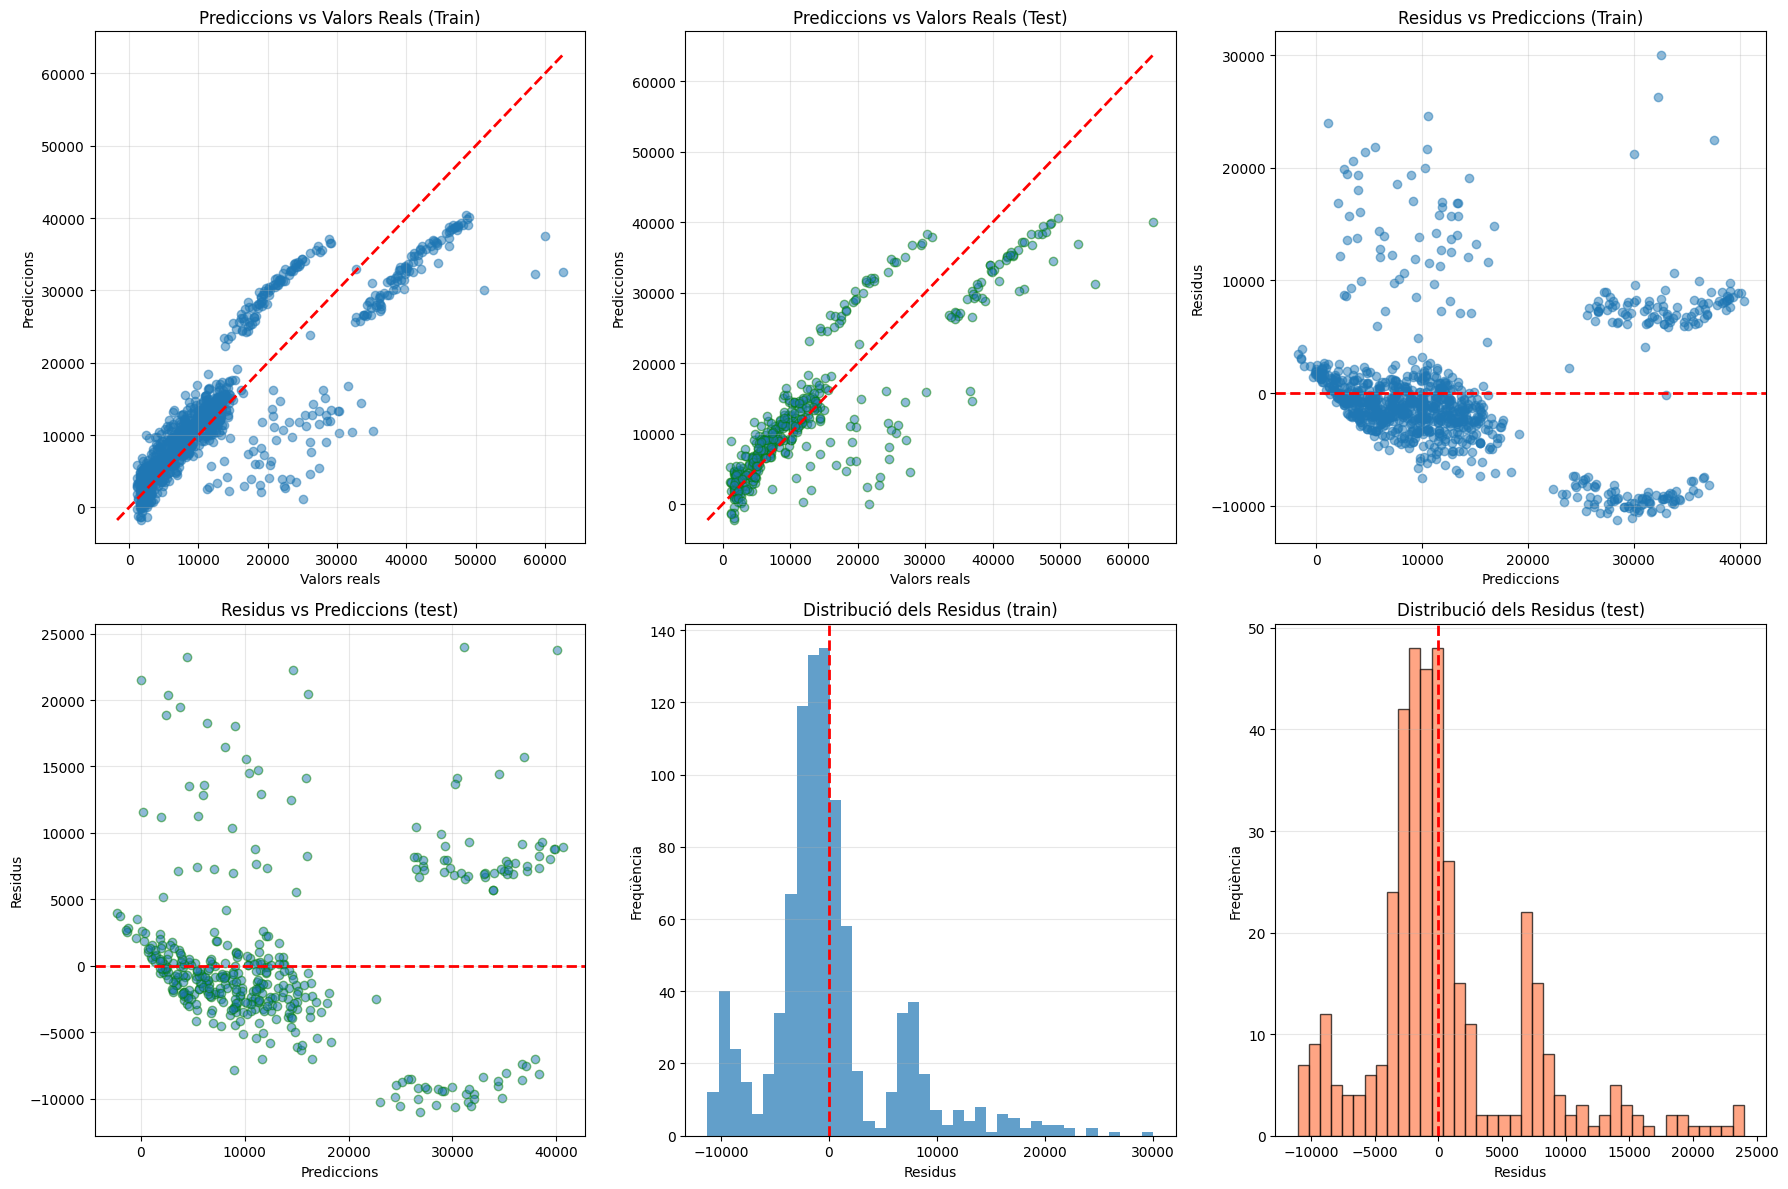

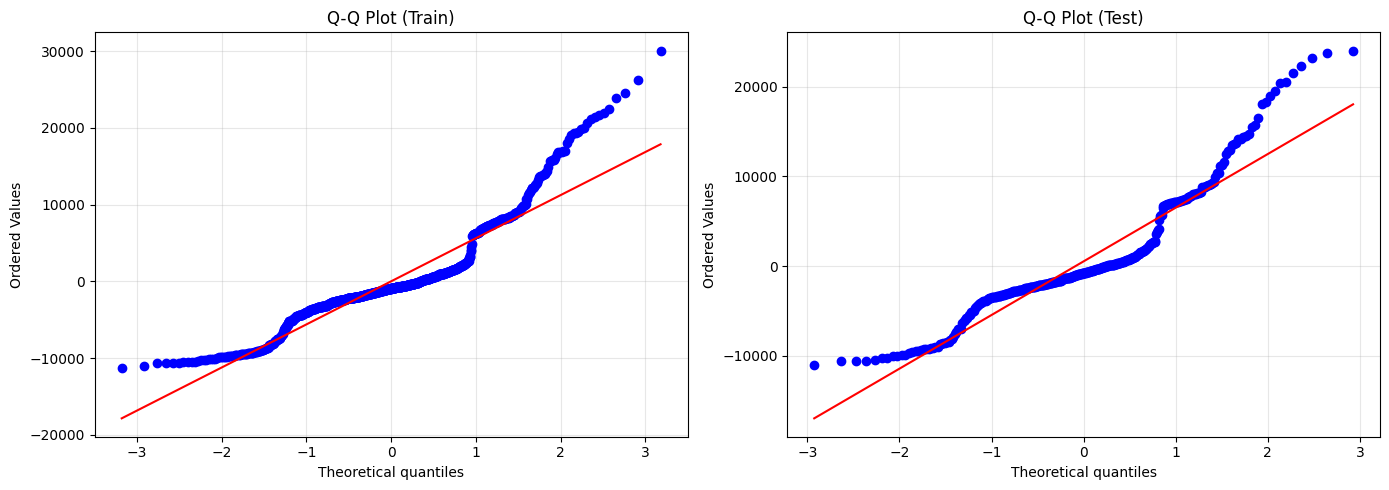

In [207]:
from scipy import stats


residus_train = y_train - y_pred_train
residus_test = y_test - y_pred_test

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Grafic 1: Prediccions vs Valors Reals Train
axes[0, 0].scatter(y_train, y_pred_train, alpha=0.5)
min_val = min(y_train.min(), y_pred_train.min())
max_val = max(y_train.max(), y_pred_train.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 0].set_xlabel('Valors reals')
axes[0, 0].set_ylabel('Prediccions')
axes[0, 0].set_title('Prediccions vs Valors Reals (Train)')
axes[0, 0].grid(True, alpha=0.3)

# Grafic 2: Prediccions vs Valors Reals Test
axes[0, 1].scatter(y_test, y_pred_test, edgecolors='green', alpha=0.5)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 1].set_xlabel('Valors reals')
axes[0, 1].set_ylabel('Prediccions')
axes[0, 1].set_title(f'Prediccions vs Valors Reals (Test)'), 
axes[0, 1].grid(True, alpha=0.3)

# Grafic 3: Residus vs Prediccions train
axes[0, 2].scatter(y_pred_train, residus_train, alpha=0.5)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Prediccions')
axes[0, 2].set_ylabel('Residus')
axes[0, 2].set_title('Residus vs Prediccions (Train)')
axes[0, 2].grid(True, alpha=0.3)

# Grafic 4: Residus vs Prediccions test
axes[1, 0].scatter(y_pred_test, residus_test, alpha=0.5, edgecolors='green')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediccions')
axes[1, 0].set_ylabel('Residus')
axes[1, 0].set_title('Residus vs Prediccions (test)')
axes[1, 0].grid(True, alpha=0.3)

# Grafic 5: Histograma de Residus train
axes[1, 1].hist(residus_train, bins=40, alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residus')
axes[1, 1].set_ylabel('Freqüència')
axes[1, 1].set_title('Distribució dels Residus (train)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Grafic 6: Histograma de Residus test
axes[1, 2].hist(residus_test, bins=40, edgecolor='black', alpha=0.7, color='coral')
axes[1, 2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 2].set_xlabel('Residus')
axes[1, 2].set_ylabel('Freqüència')
axes[1, 2].set_title('Distribució dels Residus (test)')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q-Q Plot Train
stats.probplot(residus_train, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot (Train)')
axes[0].grid(True, alpha=0.3)

# Q-Q Plot Test
stats.probplot(residus_test, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Amb aquestes 8 gràfiques podem apreciar diverses coses importants sobre el comportament del model:
- Pels dos gràfics de **Prediccions vs Valors Reals**: S'observen clarament **tres grups** de punts, que ens fa pensar que existeixen subpoblacions diferents en les dades (probablement relacionades amb la variable `smoker`).També es pot observar quan en $charges$ més alts hi ha més errors de predicció i major dispersió. Els resultats de train i test són molt similars, indicant bona generalització, però els punts no estan distribuïts uniformement al voltant de la línia y=x.

- Pel que fa el dels **Residus vs Prediccions**: Una mica semblant al analisis anterior, s'identifiquen 3 grups, i els valors no estan distribuit uniformament. I de les tres zones que tenim, una la prediu bé, un altre la sobreprediu i l'altre subprediu. Si que n'hi ha heterocedasticitat, ja que la variabilitat dels residus no es constant. Amb aquestes dades, ens fan pensar que el model no acaba de prediure bé.

- **Distribució dels residus**: El primer que salta a la vista que no segueix una distribució normal, i també es percep que n'hi ha 3 grups (3 màxims). Cal destacar que la cua de l'esquerra és més llarga. Resumint, no segueix normalitat i és asimètric.

- **Q-Q Plots**: Els punts no segueixen la línea vermella, més bé la zigzaguegen; però en la zona central (entre -1 i 1 en els quantils teòrics) és on segueixen millor la línia, indicant que la major part dels residus és aproximadament normal. Les desviacions més importants es troben a les cues.

---

**Conclusions genrals**
Tots els gràfics són molt similars entre Ttrain i test, cosa que indica que el model generalitza correctament. Els principals problemes que s'han pogut veure són:
1. **No normalitat dels residus**
2. **Heterocedasticitat**
3. **Tres grups**

---

### Ajustar la regressió amb statsmodel

In [208]:
X_train_sm = sm.add_constant(X_train_standarized)
X_test_sm = sm.add_constant(X_test_standarized)

model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     456.9
Date:                Sun, 19 Oct 2025   Prob (F-statistic):          4.06e-273
Time:                        16:32:33   Log-Likelihood:                -9462.1
No. Observations:                 936   AIC:                         1.894e+04
Df Residuals:                     929   BIC:                         1.897e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.306e+04    195.020     66.961      0.0

Analitzant el resum de statsmodels, podem extreure les següents conclusions:

La majoria de variables son siginficatives ja que **p < 0.05**:
1. **smoker** (p ≈ 0, coef = + 9399): Eś de les variables mes imortants, és a dir, ser fumador augmenta significativament els costos. 
2. **age** (p ≈ 0, coef = + 3690): Aquí podem interpretar que a més edat els costos soncostos significativament més alts.
3. **bmi** (p ≈ 0, coef = + 1881): BMI és de les últimes variables significatives que afecten drasticament al costos, quan més bmi, més es paga.
4. **children** (p = 0.003, coef = + 592):  És significant però amb poc impacte.
5. **region** (p = 0.032, coef = - 426): Igual que $children$, és significant però amb poc impacte.

En canvi, la única variable no significativa és **sex** (p = 0.621, coef = + 97), no té un efecte significatiu.


**Conclusió**: El model globalment és significatiu ja que F-statistic = 456.9 i p ≈ 0, les tres variables claus, son les que ja hem dit durant tot l'estudi $age$, $bmi$ i $smoker$, i la variable $sex$ es podria eliminar ja que no aporta poder predictiu.

---

## Apartat c)
- La relació entre variables podria no se linea, utilitza la funció PolynomialFeatures de scikit-learn per afegir característiques al conjunt.
- Ajusta les noves dades a un model de regresió lineal.
- Comentar amb la regressio original.

---

### Afegir característiques polinomials al conjunt

In [209]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_standarized)
X_test_poly = poly.transform(X_test_standarized)

print(f"Dimensions orignals (train): {X_train_standarized.shape}")
print(f"Dimensions polinomques (train): {X_train_poly.shape}")

poly.get_feature_names_out(X_train.columns)



Dimensions orignals (train): (936, 6)
Dimensions polinomques (train): (936, 27)


array(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'age^2',
       'age sex', 'age bmi', 'age children', 'age smoker', 'age region',
       'sex^2', 'sex bmi', 'sex children', 'sex smoker', 'sex region',
       'bmi^2', 'bmi children', 'bmi smoker', 'bmi region', 'children^2',
       'children smoker', 'children region', 'smoker^2', 'smoker region',
       'region^2'], dtype=object)

Veiem que em passat de tenir 6 variables per explciar el nostre model a 27, ara falta veure si milloren en la regressió. De les variables que ha creat, veiem efectivament que com a máxim son de grau 2.

---

### Ajustar les dades a un model de regressió lineal

In [210]:
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

y_pred_train_poly = lr_poly.predict(X_train_poly)
y_pred_test_poly = lr_poly.predict(X_test_poly)

#train
r2_train_poly = r2_score(y_train, y_pred_train_poly)
mse_train_poly = mean_squared_error(y_train, y_pred_train_poly)
rmse_train_poly = np.sqrt(mse_train_poly)
mae_train_poly = mean_absolute_error(y_train, y_pred_train_poly)

# test
r2_test_poly = r2_score(y_test, y_pred_test_poly)
mse_test_poly = mean_squared_error(y_test, y_pred_test_poly)
rmse_test_poly = np.sqrt(mse_test_poly)
mae_test_poly = mean_absolute_error(y_test, y_pred_test_poly)

print(f"R2 entrenament polinomial: {r2_train_poly:.4f} \nMSE entrenament polinomial: {mse_train_poly:.2f} \nRMSE entrenament polinomial: {rmse_train_poly:.4f} \nMAE entrenament polinomial: {mae_train_poly:.4f}")
print(f"R2 test polinomial: {r2_test_poly:.4f} \nMSE test polinomial: {mse_test_poly:.2f} \nRMSE test polinomial: {rmse_test_poly:.4f} \nMAE test polinomial: {mae_test_poly:.4f}")
print('-'*90)
print('Comparació amb model lineal original:')
print(f'Diferencia R2 entrenament: {r2_train_poly - r2_train:.4f}')
print(f'Diferencia R2 test: {r2_test_poly - r2_test:.4f}')
print(f'Diferencia RMSE entrenament: {rmse_train_poly-rmse_train:.4f}')
print(f'Diferencia RMSE test: {rmse_test_poly-rmse_test:.4f}')

R2 entrenament polinomial: 0.8440 
MSE entrenament polinomial: 21779070.70 
RMSE entrenament polinomial: 4666.8052 
MAE entrenament polinomial: 2784.9015
R2 test polinomial: 0.8471 
MSE test polinomial: 24818804.08 
RMSE test polinomial: 4981.8475 
MAE test polinomial: 3008.5681
------------------------------------------------------------------------------------------
Comparació amb model lineal original:
Diferencia R2 entrenament: 0.0971
Diferencia R2 test: 0.0914
Diferencia RMSE entrenament: -1277.3022
Diferencia RMSE test: -1316.2187


Es pot observar clarament que el model polinomial s'adapata millor al problema, ja que comparant amb l'original destaca a millor significativament. Punts clau per afirmar-ho:
- R² de 84% vs el 75% del lineal.
- RMSE de ≈ 5000 davant els ≈ 6000 del lineal.
- MAE de ≈ 3.009 vs ≈ 4.318

És a dir, el model polinomic te en conta relacions no lineals i també te un cost de computació més elevat, ja que ha de tenir en conta mes variables, però aquest cost es pot justificar amb la millora del poder predictiu.

---

## Apartat d)

- Aplica LASSO per veure si es pot reduir el número de variables
- Compara la qualitat del model
- Analitza la importància de pesos d'aquest model, quina importància tenen les variables?

---

### LASSO

In [211]:
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

lasso_cv = LassoCV(cv=5, random_state=92, max_iter=10000)
lasso_cv.fit(X_train_poly_scaled, y_train)

y_pred_train_lasso = lasso_cv.predict(X_train_poly_scaled)
y_pred_test_lasso = lasso_cv.predict(X_test_poly_scaled)

r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)
mae_train_lasso = mean_absolute_error(y_train, y_pred_train_lasso)

r2_test_lasso = r2_score(y_test, y_pred_test_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)


print(f'Millor alpha: {lasso_cv.alpha_:.6f}')
metrics_train_lasso = {
    'R²': r2_train_lasso,
    'MSE': mse_train_lasso,
    'RMSE': rmse_train_lasso,
    'MAE': mae_train_lasso
}
metrics_test_lasso = {
    'R²': r2_test_lasso,
    'MSE': mse_test_lasso,
    'RMSE': rmse_test_lasso,
    'MAE': mae_test_lasso
}
print('LASSO metrics (train):', metrics_train_lasso)
print('LASSO metrics (test) :', metrics_test_lasso)
print('-'*90)

caracteristiques = poly.get_feature_names_out(X_train.columns)
coef = lasso_cv.coef_
coef_df = pd.DataFrame({'caracteristiques': caracteristiques, 'coef': coef})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

non_zero = (coef != 0).sum()
total = len(coef)
print(f'Coeficients amb valor diferent a 0: {non_zero}/{total} ({non_zero/total*100:.2f}%)')
print('-'*90)


Millor alpha: 80.416137
LASSO metrics (train): {'R²': 0.8426707516495351, 'MSE': 21963339.907417778, 'RMSE': np.float64(4686.506151432833), 'MAE': 2800.3611602251194}
LASSO metrics (test) : {'R²': 0.8485476860898492, 'MSE': 24589556.061028752, 'RMSE': np.float64(4958.785744618208), 'MAE': 2995.760948489545}
------------------------------------------------------------------------------------------
Coeficients amb valor diferent a 0: 20/27 (74.07%)
------------------------------------------------------------------------------------------


Es poden reduir 7 variables ja que el seu coeficient es 0, i en LASSO si es 0 no és te en conta.

In [212]:
results = pd.DataFrame({
    'model': ['Linear', 'Poly2 + Linear', 'Lasso Poly2'],
    'r2_test': [r2_test, r2_test_poly, r2_test_lasso],
    'rmse_test': [rmse_test, rmse_test_poly, rmse_test_lasso],
    'mae_test': [mae_test, mae_test_poly, mae_test_lasso],
    'rmse_test': [rmse_test, rmse_test_poly, rmse_test_lasso]
})
print("\nResum comparatiu dels models:")
display(results)


Resum comparatiu dels models:


,model,r2_test,rmse_test,mae_test
0,Linear,0.755691,6298.066193,4318.480735
1,Poly2 + Linear,0.847136,4981.847457,3008.568081
2,Lasso Poly2,0.848548,4958.785745,2995.760948


Es veu clarament que el que menys prediu es el linial, tot i que te un R² molt bo, els altres dos el superen. Respecte poly 2 i Lasso, el resultats son molt similars, però s'ha de tenir en conta que en el poly es tenen en conta 27 variables mentres que en el LASSO només es tenen en compte 20, ja que n'hi ha 7 amb coeficient 0. Posats a triar em quedaria amb LASSO, ja que redueix les variables respecte el poly i segueix tenint el mateix output amb menys complecitat.

In [213]:
display(coef_df.head(20))

,caracteristiques,coef,abs_coef
4,smoker,9298.983454,9298.983454
0,age,3597.583185,3597.583185
19,bmi smoker,3468.189459,3468.189459
2,bmi,1769.359071,1769.359071
3,children,852.192123,852.192123
6,age^2,471.977370,471.977370
5,region,-465.494947,465.494947
17,bmi^2,-376.479210,376.479210
23,children region,-225.530347,225.530347
21,children^2,-187.996471,187.996471


L'analisi de LASSO confirma el que haviem dit inicialment, però complementant també. Efectivament  $smoker$, $age$ i $bmi$ son de les variables més predictores.

La variable $smoker$ és la que més destaca, amb un coeficient de 9298.98$, això vol dir que per ser fumador el cost augmenta en gairabé 9300$; pasa algo semblan amb $age$, que es veu que es acumulativa en funció del anys, quan més se'n té, més es paga, uns 3600$ l'any de més.

Però la variable que encara no haiva aparegut es la de $bmi$ $smoker$, és una interacció crítica, vol dir que els fumadors amb alt bmi tenen costos expotencialment més grans, però era una observació que ja havíem anat comentant, però el model LASSO l'ha mostrada.

D'altra banda, la variable $sex$ confirma la seva irrellevància predictiva, és a dir, te un podeu prediticu irrisori i es podria eliminar del model sense afectar a la capacitat predictiva.